##### source: https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/movie_recommendation_using_NeuMF.ipynb

In [172]:
import os

# data science imports
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K

# sklearn imports
from sklearn.model_selection import train_test_split

# keras/tensorflow imports
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

# from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# visualization imports
import matplotlib.pyplot as plt
%matplotlib inline

In [215]:
def load_ratings():
    COL_NAME = ['uid','mid','rating','timestamp']
    df = pd.read_csv('data/movie-ratings.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def load_movies():
    COL_NAME = ['mid','movie_name','movie_genre']
    df = pd.read_csv('data/movie-movies.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def load_users():
    COL_NAME = ['uid','user_fea1','user_fea2','user_fea3','user_fea4']
    df = pd.read_csv('data/movie-users.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

In [174]:
ratings = load_ratings()
ratings.head()

,uid,mid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [175]:
num_users = len(ratings.uid.unique())
num_items = len(ratings.mid.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 6040 unique users and 3706 unique movies in this data set


In [176]:
user_max_id = ratings.uid.max()
item_max_id = ratings.mid.max()
print('There are {} distinct users and the max of uid is also {}'.format(num_users, user_max_id))
print('There are {} distinct movies, however, the max of mid is {}'.format(num_items, item_max_id))
print('In the context of matrix factorization, the current item vector is in unnecessarily high dimensional space')
print('So we need to do some data cleaning to reduce the dimension of item vector back to {}'.format(num_items))

There are 6040 distinct users and the max of uid is also 6040
There are 3706 distinct movies, however, the max of mid is 3952
In the context of matrix factorization, the current item vector is in unnecessarily high dimensional space
So we need to do some data cleaning to reduce the dimension of item vector back to 3706


In [177]:
def reduce_item_dim(ratings):
    """
    Reduce item vector dimension to the number of distinct items in our data sets
    
    input : pd.DataFrame, ratings should have columns ['uid', 'mid', 'rating']
    output: pd.DataFrame, ratings with new 'mid' that is compressed
    """
    # pivot
    user_item = ratings.pivot(index='uid', columns='mid', values='rating')
    
    # reset mid
    user_item = user_item.T.reset_index(drop=True).T
    
    # undo pivot/melt - compress data frame
    ratings_new = user_item.reset_index('uid').melt(id_vars='uid', value_vars=user_item.columns, var_name='mid', value_name='rating')

    # drop nan and final clean up
    ratings_new = ratings_new.dropna().sort_values(['uid', 'mid']).reset_index(drop=True)
    
#     return ratings_new
    return ratings_new.astype(int)
    """
    note:
    Your sample data may not show it, but the results of your pivot operation possibly contain NaNs,
    which are of float type, so the rest of the column is also upcasted to float automatically by pandas for efficient computation.
    Note that the NaNs are filled by zeros (fill_value=0), so you don't get to see them.
    For example, there is no row with objectid = 32233 and value = 0, so that corresponding entry in your pivot result shows up as NaN,
    which then gets filled with 0.
    Now that it's clear why the columns are upcasted, you can reset the datatype using astype:
    p = p.astype(int)
    """

In [178]:
print('reduce item dimension before:')
ratings.head()

reduce item dimension before:


,uid,mid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [179]:
ratings = reduce_item_dim(ratings)
print('reduce item dimension after:')
ratings.head()

reduce item dimension after:


,uid,mid,rating
0,1,0,5
1,1,47,5
2,1,144,5
3,1,253,4
4,1,513,5


##### Split Data Into Train/Test

In [180]:
train, test = train_test_split(ratings, test_size=0.2, shuffle=True, random_state=99)
print('shape of training data set:')
print(train.shape)
print('shape of test data set:')
print(test.shape)

shape of training data set:
(800167, 3)
shape of test data set:
(200042, 3)


##### Train Generalized Matrix Factorization and Test Model

##### define GMF model architeture and train routine

In [181]:
def get_GMF_model(num_users, num_items, latent_dim, vu_reg, vi_reg):
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    latent_dim: int, embedded dimension for user vector and item vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    mf_embedding_user = Embedding(
        input_dim = num_users + 1,
        output_dim = latent_dim,
        embeddings_initializer = 'uniform',
        name = 'user_embedding',
        embeddings_regularizer = l2(vu_reg),
        input_length = 1
    )
    
    mf_embedding_item = Embedding(
        input_dim = num_items + 1,
        output_dim = latent_dim,
        embeddings_initializer = 'uniform',
        name = 'item_embedding',
        embeddings_regularizer = l2(vi_reg),
        input_length = 1
    ) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(mf_embedding_user(user_input))
    item_latent = Flatten()(mf_embedding_item(item_input))

    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs, filepath):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
    # compile model
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath=filepath, monitor='val_rmse', save_best_only=True, save_weights_only=True)
    
    # train model
    history = model.fit(inputs, outputs, batch_size=batch_size, epochs=epochs, validation_split=val_split, callbacks=[early_stopper, model_saver])
    
    return history

def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

##### create GMF model

In [182]:
GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0)
GMF_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        60410       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        37070       item_input[0][0]                 
___________________________________________________________________________________________

##### train GMF model

In [183]:
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(
    GMF_model,
    'adam',
    BATCH_SIZE,
    EPOCHS,
    VAL_SPLIT,
    inputs=[train.uid.values, train.mid.values],
    outputs=train.rating.values,
    filepath='model/neural-gmf-weights.hdf5')

Train on 600125 samples, validate on 200042 samples
Epoch 1/30
600125/600125 [==============================] - 13s 21us/sample - loss: 2.5135 - mean_squared_error: 2.5136 - rmse: 1.3748 - val_loss: 0.8807 - val_mean_squared_error: 0.8807 - val_rmse: 0.9347
Epoch 2/30
600125/600125 [==============================] - 13s 21us/sample - loss: 0.8402 - mean_squared_error: 0.8402 - rmse: 0.9126 - val_loss: 0.8236 - val_mean_squared_error: 0.8236 - val_rmse: 0.9036
Epoch 3/30
600125/600125 [==============================] - 13s 22us/sample - loss: 0.7762 - mean_squared_error: 0.7762 - rmse: 0.8771 - val_loss: 0.7959 - val_mean_squared_error: 0.7959 - val_rmse: 0.8882
Epoch 4/30
600125/600125 [==============================] - 13s 21us/sample - loss: 0.7331 - mean_squared_error: 0.7331 - rmse: 0.8522 - val_loss: 0.7801 - val_mean_squared_error: 0.7801 - val_rmse: 0.8794
Epoch 5/30
600125/600125 [==============================] - 13s 21us/sample - loss: 0.6995 - mean_squared_error: 0.6995 - rm

In [184]:
def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

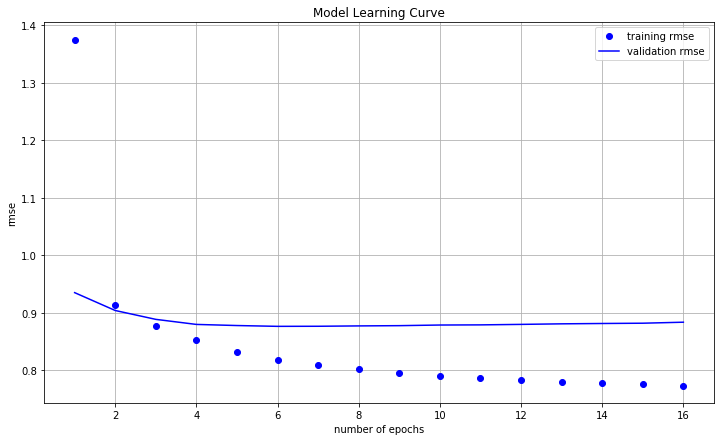

In [185]:
plot_learning_curve(history, 'rmse')

##### GMF model testing

In [186]:
# define rmse function
rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions) - np.squeeze(test.rating.values))))

In [187]:
# load best model
GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0)
GMF_model = load_trained_model(GMF_model, 'model/neural-gmf-weights.hdf5')

# make prediction using test data
predictions = GMF_model.predict([test.uid.values, test.mid.values])

# get the RMSE
error = rmse(test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8812


#### Train Multi-Layer Perceptron Model and Test Model

##### define MLP model architeture

In [188]:
def get_MLP_model(num_users, num_items, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    mlp_embedding_user = Embedding(
        input_dim=num_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    
    mlp_embedding_item = Embedding(
        input_dim=num_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(mlp_embedding_user(user_input))
    item_latent = Flatten()(mlp_embedding_item(item_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

##### create MLP model

In [189]:
MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 32)        193312      user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 32)        118624      item_input[0][0]                 
___________________________________________________________________________________________

##### train MLP model

In [190]:
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(
    MLP_model,
    'adam',
    BATCH_SIZE,
    EPOCHS,
    VAL_SPLIT,
    inputs=[train.uid.values, train.mid.values],
    outputs=train.rating.values,
    filepath='model/neural-mlp-weights.hdf5')

Train on 600125 samples, validate on 200042 samples
Epoch 1/30
600125/600125 [==============================] - 19s 31us/sample - loss: 0.9362 - mean_squared_error: 0.9362 - rmse: 0.9451 - val_loss: 0.8230 - val_mean_squared_error: 0.8230 - val_rmse: 0.9033
Epoch 2/30
600125/600125 [==============================] - 18s 30us/sample - loss: 0.8011 - mean_squared_error: 0.8011 - rmse: 0.8910 - val_loss: 0.7960 - val_mean_squared_error: 0.7960 - val_rmse: 0.8884
Epoch 3/30
600125/600125 [==============================] - 18s 31us/sample - loss: 0.7665 - mean_squared_error: 0.7665 - rmse: 0.8714 - val_loss: 0.7856 - val_mean_squared_error: 0.7856 - val_rmse: 0.8824
Epoch 4/30
600125/600125 [==============================] - 18s 31us/sample - loss: 0.7409 - mean_squared_error: 0.7409 - rmse: 0.8566 - val_loss: 0.7864 - val_mean_squared_error: 0.7864 - val_rmse: 0.8827
Epoch 5/30
600125/600125 [==============================] - 19s 31us/sample - loss: 0.7149 - mean_squared_error: 0.7149 - rm

##### MLP learning curve

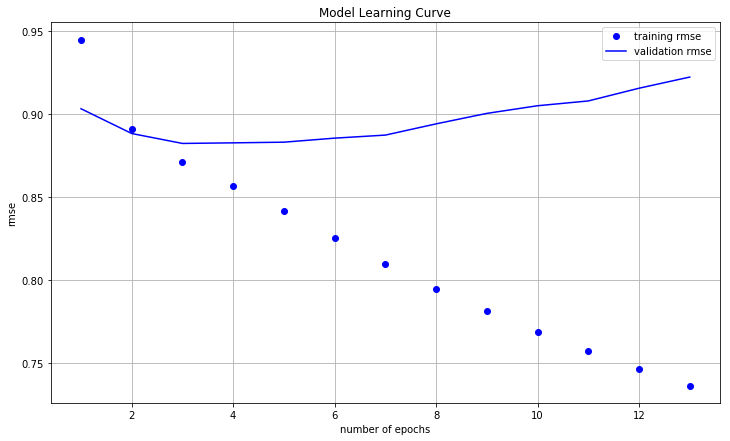

In [191]:
plot_learning_curve(history, 'rmse')

#### MLP model testing

##### And finally, make a prediction and check the testing error using out-of-sample data

In [192]:
# load best model
MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model = load_trained_model(MLP_model, 'model/neural-mlp-weights.hdf5')

# make prediction using test data
predictions = MLP_model.predict([test.uid.values, test.mid.values])

# get the RMSE
error = rmse(test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8869


#### Train Neural Matrix Factorization (NeuralMF) and Test Model

##### define NeuralMF model architeture

In [193]:
def get_NeuralMF_model(num_users, num_items, MF_dim, MF_reg, MLP_layers, MLP_regs):
    """
    Build Neural Matrix Factorization (NeuralMF) Model Topology.
    This is stack version of both GMF and MLP
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    MF_dim: int, embedded dimension for user vector and item vector in MF
    MF_reg: tuple of float, L2 regularization of MF embedded layer
    MLP_layers: list of int, each element is the number of hidden units for each MLP layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    MLP_regs: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # MF Embedding layer
    mf_embedding_user = Embedding(
        input_dim=num_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    
    mf_embedding_item = Embedding(
        input_dim=num_items + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    # MLP
    mlp_embedding_user = Embedding(
        input_dim=num_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    
    mlp_embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    
    # MF part
    mf_user_latent = Flatten()(mf_embedding_user(user_input))
    mf_item_latent = Flatten()(mf_embedding_item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part
    mlp_user_latent = Flatten()(mlp_embedding_user(user_input))
    mlp_item_latent = Flatten()(mlp_embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])

    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    
    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

##### create NeuralMF model

In [194]:
NeuralMF_model = get_NeuralMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuralMF_model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        193312      user_input[0][0]                 
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        118624      item_input[0][0]                 
___________________________________________________________________________________________

##### train NeuralMF model

In [195]:
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(
    NeuralMF_model,
    'adam',
    BATCH_SIZE,
    EPOCHS,
    VAL_SPLIT,
    inputs=[train.uid.values, train.mid.values],
    outputs=train.rating.values,
    filepath='model/neural-nmf-weights.hdf5')

Train on 600125 samples, validate on 200042 samples
Epoch 1/30
600125/600125 [==============================] - 26s 43us/sample - loss: 0.9615 - mean_squared_error: 0.9615 - rmse: 0.9511 - val_loss: 0.8217 - val_mean_squared_error: 0.8217 - val_rmse: 0.9028
Epoch 2/30
600125/600125 [==============================] - 23s 38us/sample - loss: 0.7613 - mean_squared_error: 0.7613 - rmse: 0.8685 - val_loss: 0.7914 - val_mean_squared_error: 0.7914 - val_rmse: 0.8855
Epoch 3/30
600125/600125 [==============================] - 23s 38us/sample - loss: 0.6889 - mean_squared_error: 0.6889 - rmse: 0.8259 - val_loss: 0.7975 - val_mean_squared_error: 0.7975 - val_rmse: 0.8887
Epoch 4/30
600125/600125 [==============================] - 23s 38us/sample - loss: 0.6485 - mean_squared_error: 0.6485 - rmse: 0.8012 - val_loss: 0.7980 - val_mean_squared_error: 0.7980 - val_rmse: 0.8891
Epoch 5/30
600125/600125 [==============================] - 23s 39us/sample - loss: 0.6194 - mean_squared_error: 0.6194 - rm

##### Neural Matrix Factorization (NeuralMF) learning curve

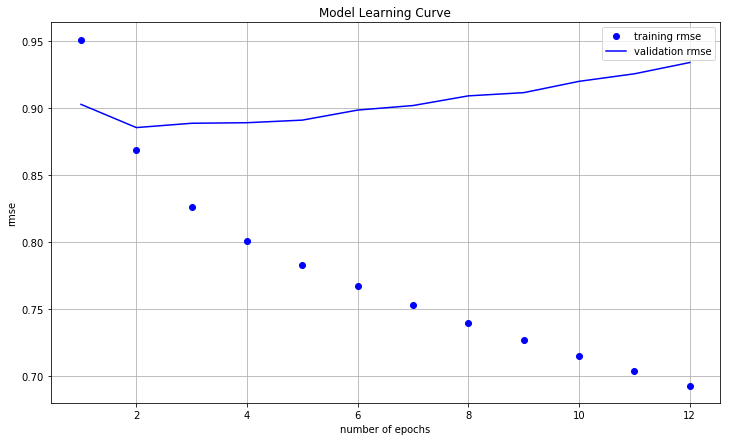

In [196]:
plot_learning_curve(history, 'rmse')

##### Neural Matrix Factorization (NeuralMF) model testing

##### And finally, make a prediction and check the testing error using out-of-sample data

In [197]:
# load best model
NeuralMF_model = get_NeuralMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuralMF_model = load_trained_model(NeuralMF_model, 'model/neural-nmf-weights.hdf5')

# make prediction using test data
predictions = NeuralMF_model.predict([test.uid.values, test.mid.values])

# get the RMSE
error = rmse(test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8901


##### Recomendation

In [300]:
ratings = load_ratings()
ratings = reduce_item_dim(ratings)

In [371]:
# Creating dataset for making recommendations for the user
uid = 1975
movie_data = np.array(list(set(ratings.mid)))
user_data = np.array([uid for i in range(len(movie_data))])

In [372]:
users = load_users()
movies = load_movies()
users_movies_ratings = ratings.join(movies.set_index('mid'), on = 'mid', how = 'left')
users_movies_ratings = users_movies_ratings.join(users.set_index('uid'), on = 'uid', how = 'left')

user_preferences = users_movies_ratings[(users_movies_ratings.uid == uid)].sort_values(['rating'], ascending=[0])
user_preferences = user_preferences[user_preferences['movie_name'].notnull()]
user_preferences[['uid','mid','rating','movie_name','movie_genre']].head(10)

,uid,mid,rating,movie_name,movie_genre
344300,2020,3266,5,Man Bites Dog (C'est arrivé près de chez vous)...,Action|Comedy|Crime|Drama
343993,2020,1025,5,"Sword in the Stone, The (1963)",Animation|Children's
344301,2020,3272,5,Bad Lieutenant (1992),Crime|Drama
344254,2020,2888,5,Drive Me Crazy (1999),Comedy|Romance
344303,2020,3275,5,"Boondock Saints, The (1999)",Action|Comedy
344253,2020,2873,5,Lulu on the Bridge (1998),Drama|Mystery|Romance
344249,2020,2851,5,Saturn 3 (1979),Adventure|Sci-Fi|Thriller
344306,2020,3291,5,Trois (2000),Thriller
343984,2020,1003,5,Extreme Measures (1996),Drama|Thriller
343982,2020,971,5,Cat on a Hot Tin Roof (1958),Drama


In [373]:
predictions = NeuralMF_model.predict([user_data, movie_data])
predictions = np.array([a[0] for a in predictions])
recommended_movie_ids = (-predictions).argsort()[:10]

recomendations = users_movies_ratings[users_movies_ratings['mid'].isin(recommended_movie_ids)]
recomendations = recomendations[recomendations['movie_name'].notnull()]
recomendations = recomendations.drop_duplicates(subset='movie_name', keep="last")
recomendations[['uid','mid','rating','movie_name','movie_genre']].head(10)

,uid,mid,rating,movie_name,movie_genre
999737,6038,1288,2,This Is Spinal Tap (1984),Comedy|Drama|Musical
999891,6040,253,4,Interview with the Vampire (1994),Drama|Horror
999898,6040,309,4,"Red Firecracker, Green Firecracker (1994)",Drama
999944,6040,971,3,Cat on a Hot Tin Roof (1958),Drama
999969,6040,1106,3,"Leopard Son, The (1996)",Documentary
999970,6040,1108,3,Prerokbe Ognja (1995),Documentary
999972,6040,1110,3,Bird of Prey (1996),Action
999992,6040,1148,3,"Wrong Trousers, The (1993)",Animation|Comedy
1000009,6040,1178,3,Paths of Glory (1957),Drama|War
1000144,6040,2557,4,I Stand Alone (Seul contre tous) (1998),Drama
